# House Prices (v1)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# Evaluation index is RMSE, so prepare a library calculatable the mean squared error.
from sklearn.metrics import mean_squared_error

In [2]:
DF_TRAIN = pd.read_csv('./raw_data/train.csv')
DF_TEST = pd.read_csv('./raw_data/test.csv')
SAMPLE_SUBMISSION = pd.read_csv('./raw_data/sample_submission.csv')

# data confirmation
display(DF_TRAIN.head(3))
display(DF_TEST.head(3))
display(SAMPLE_SUBMISSION.head(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570


In [3]:
DF_TRAIN.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [4]:
DF_TRAIN['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
df_all = pd.concat(
    [DF_TRAIN, DF_TEST],
    sort=False
).reset_index(drop=True)

df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [6]:
objective_categories = df_all.columns[df_all.dtypes == 'object']

print(objective_categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [7]:
# Label encode
label_encodered_df_all = df_all

for category in objective_categories:
    label_encoder = LabelEncoder()
    
    label_encodered_df_all[category].fillna(
        'missing_value', inplace=True
    )
    label_encoder.fit(label_encodered_df_all[category])
    label_encodered_df_all[category] = label_encoder.transform(label_encodered_df_all[category])
    label_encodered_df_all[category] = label_encodered_df_all[category].astype('category')

In [8]:
train = label_encodered_df_all[~label_encodered_df_all['SalePrice'].isnull()]
test = label_encodered_df_all[label_encodered_df_all['SalePrice'].isnull()]

display(train.head(3))
display(test.head(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1460,1461,20,2,80.0,11622,1,2,3,3,0,...,0,3,2,4,0,6,2010,8,4,NaN
1461,1462,20,3,81.0,14267,1,2,0,3,0,...,0,3,4,0,12500,6,2010,8,4,NaN
1462,1463,60,3,74.0,13830,1,2,0,3,0,...,0,3,2,4,0,3,2010,8,4,NaN


In [9]:
train_X = train.drop(
    ['SalePrice', 'Id'],
    axis=1
)
train_y = train['SalePrice']

kf = KFold(n_splits=3)

lgb_params = {
    'objective': 'regression',
    'random_seed': 1000
}

In [10]:
models = []
rmses = []
out_of_fold = np.zeros(
    len(train_X)
)

callbacks = [
    lgb.early_stopping(20),
    lgb.log_evaluation(10)
]

for train_index, value_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[value_index]
    y_train = train_y.iloc[train_index]
    y_valid = train_y.iloc[value_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(
        X_valid,
        y_valid,
        reference=lgb_train
    )

    gbm = lgb.train(
        lgb_params,
        train_set=lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=100,
        callbacks=callbacks
    )

    y_pred = gbm.predict(
        X_valid,
        num_iteration=gbm.best_iteration
    )
    _rmse = np.sqrt(mean_squared_error(
        np.log(y_valid),
        np.log(y_pred)
    ))

    models += [gbm]
    rmses += [_rmse]
    out_of_fold[value_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.57807e+09
[20]	valid_0's l2: 7.38516e+08
[30]	valid_0's l2: 5.93255e+08
[40]	valid_0's l2: 5.6061e+08
[50]	valid_0's l2: 5.48225e+08
[60]	valid_0's l2: 5.46182e+08
[70]	valid_0's l2: 5.51735e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08


/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 180923.739979
[10]	valid_0's l2: 2.089e+09
[20]	valid_0's l2: 1.22218e+09
[30]	valid_0's l2: 1.03767e+09
[40]	valid_0's l2: 9.7989e+08
[50]	valid_0's l2: 9.47475e+08
[60]	valid_0's l2: 9.27892e+08
[70]	valid_0's l2: 9.20973e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 75


/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 182112.591376
[10]	valid_0's l2: 1.80296e+09
[20]	valid_0's l2: 1.02271e+09
[30]	valid_0's l2: 8.68838e+08
[40]	valid_0's l2: 8.41872e+08
[50]	valid_0's l2: 8.35433e+08
[60]	valid_0's l2: 8.28083e+08
[70]	valid_0's l2: 8.25289e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08


In [11]:
print(rmses)

[0.12719558859476138, 0.1481698339125757, 0.13266748681202264]


In [12]:
# Average RMSE
sum(rmses) / len(rmses)

0.1360109697731199

<AxesSubplot: xlabel='Id', ylabel='SalePrice'>

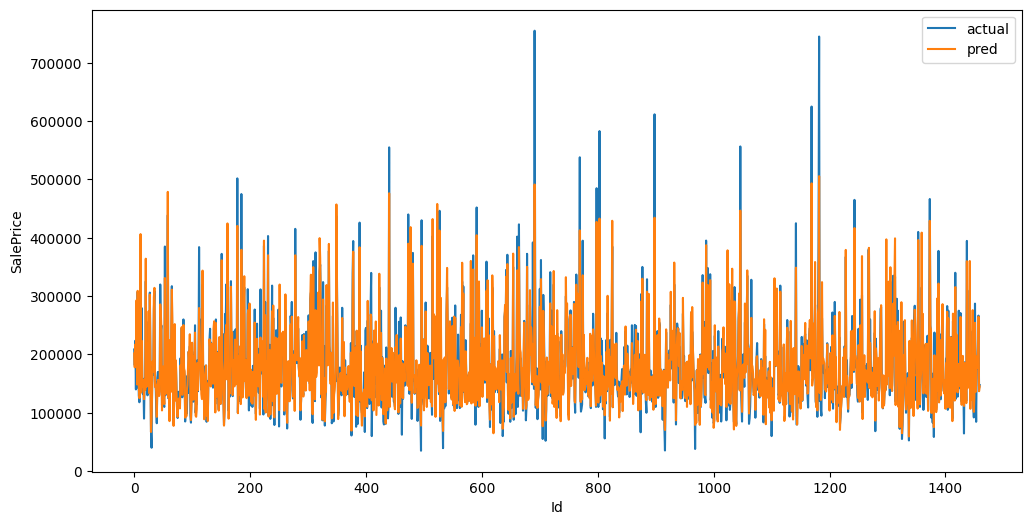

In [13]:
# Visualize actual and predicted values
comparison_actual_and_pred = pd.DataFrame({
    'actual': train_y,
    'pred': out_of_fold
})

comparison_actual_and_pred.plot(
    figsize=(12, 6),
    xlabel='Id',
    ylabel='SalePrice'
)